<a href="https://colab.research.google.com/github/ashish1610dhiman/pinn_option_pricing/blob/main/european_call_pricing_0_ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from io import IncrementalNewlineDecoder
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
%matplotlib inline

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

### Analytical solution

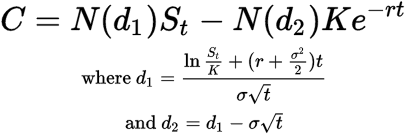

In [3]:
S = torch.Tensor([80]).requires_grad_()
t = torch.Tensor([0]).requires_grad_()
sigma = torch.Tensor([0.3]).requires_grad_()
r = torch.Tensor([0.05]).requires_grad_()
K = torch.Tensor([70])
T = torch.Tensor([1])
t2m = T-t

d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m)/(sigma * torch.sqrt(t2m))
d2 = d1 - sigma * torch.sqrt(t2m)

In [4]:
N0 = lambda value: 0.5 * (1 + torch.erf((value/2**0.5))) #normal cdf
Nd1 = N0(d1)
Nd2 = N0(d2)
C = S* Nd1 - K* Nd2 *torch.exp(-r*t2m)
print("Option Price:", C.item())

Option Price: 17.01496124267578


### Differential eqn

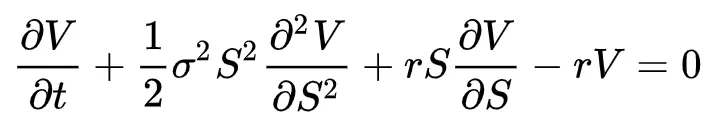

In [5]:
dCdt = tgrad.grad(C, t, create_graph=True, only_inputs=True)[0]
dCdt

tensor([-5.8385], grad_fn=<NegBackward0>)

In [6]:
dCdS = tgrad.grad(C, S, create_graph=True, only_inputs=True)[0]
d2CdS2 = tgrad.grad(dCdS, S, create_graph=True, only_inputs=True)[0]
dCdvol = tgrad.grad(C, sigma, create_graph=True, only_inputs=True)[0]
dCdS,d2CdS2,dCdvol

(tensor([0.7769], grad_fn=<AddBackward0>),
 tensor([0.0124], grad_fn=<AddBackward0>),
 tensor([23.8776], grad_fn=<AddBackward0>))

In [7]:
dCdt.item() + ((0.5*sigma**2) * (S**2)*d2CdS2.item() )+ r*S*dCdS.item() - r*C

tensor([0.], grad_fn=<SubBackward0>)

### PDE Modelling for European option

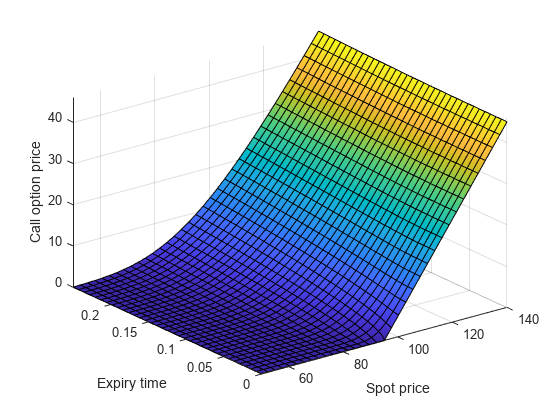

In [8]:
K = 40
r = 0.05
sigma = 0.25
T = 1
S_range = [0, 130]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)

In [9]:
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1)) #price
    return X, y

get_diff_data(10)

(array([[1.84144212e-01, 5.05977947e+01],
        [2.15717837e-01, 1.64854125e+01],
        [8.94873953e-01, 3.47966029e+00],
        [6.52931379e-01, 7.13057637e+01],
        [4.22003240e-02, 2.96811683e+01],
        [2.45444004e-01, 1.19770775e+02],
        [4.60032219e-01, 1.20257571e+02],
        [3.68726442e-01, 1.29077345e+00],
        [1.18911468e-01, 6.02252709e+01],
        [7.98462293e-01, 6.07600649e+01]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [10]:
def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)), #all at expiry time
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)

    return X, y

get_ivp_data(10)

(array([[  1.        , 114.22309601],
        [  1.        , 111.35046112],
        [  1.        ,  43.98780988],
        [  1.        ,  76.44523601],
        [  1.        ,  30.49256767],
        [  1.        ,  76.66030004],
        [  1.        , 102.56436315],
        [  1.        ,  10.56679494],
        [  1.        ,  99.67105197],
        [  1.        ,  14.898454  ]]),
 array([[74.22309601],
        [71.35046112],
        [ 3.98780988],
        [36.44523601],
        [ 0.        ],
        [36.66030004],
        [62.56436315],
        [ 0.        ],
        [59.67105197],
        [ 0.        ]]))

In [11]:
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2



* BVP 1 $S = S_{min}$: 0

* BVP2 ($S = S_{max}$): $S_{max} - K \cdot e^{-rt}$

* IVP (t=T): $max(S-K,0)$ *call this initial but corresponds to expiry*

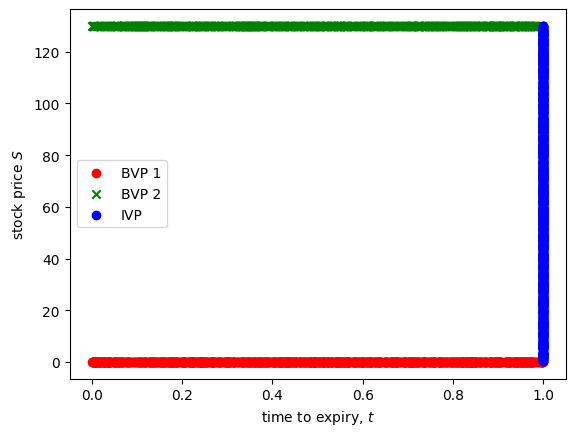

In [41]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = get_bvp_data(1000)
ivp_x1,ivp_y1 = get_ivp_data(1000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.xlabel("time to expiry, $t$")
plt.ylabel("stock price $S$")
plt.legend()

# Simulation with PINN

In [13]:
class european_call(nn.Module):
    "Defines a Phsyics informed network"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation1 = nn.LeakyReLU(negative_slope=0.1)
        activation2 = nn.Tanh()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation1])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation1,\
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation2]) for _ in range(N_LAYERS//2)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### declare model

In [14]:
model = european_call(2,1,64,10)
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
print (f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

Model parameters : 165.63K


In [15]:
N_sample = 500
physics_lr = 10

loss_history={
    "total_loss":[],"loss1":[],"loss2":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}

for i in range(10000):
    optimizer.zero_grad()

    # Get IVP data
    ivp_x, ivp_y = get_ivp_data(N_sample)
    ivp_x_tensor = torch.from_numpy(ivp_x).float()
    ivp_y_tensor = torch.from_numpy(ivp_y).float()
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1, bvp_y1, bvp_x2, bvp_y2 = get_bvp_data(N_sample)
    bvp_x1_tensor = torch.from_numpy(bvp_x1).float()
    bvp_y1_tensor = torch.from_numpy(bvp_y1).float()
    bvp_x2_tensor = torch.from_numpy(bvp_x2).float()
    bvp_y2_tensor = torch.from_numpy(bvp_y2).float()
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y1_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1, y1 = get_diff_data(N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_()
    y1 = torch.from_numpy(y1).float()
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + 0.5 * ((sigma * S1) ** 2) * d2VdS2 + r * S1 * dVdS - r * y1_hat
    loss2 = physics_lr * torch.mean(bs_pde ** 2)

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss1"].append(loss1.item())
    loss_history["loss2"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    loss.backward()
    optimizer.step()


    # Plot the result as training progresses
    if (i + 1) % 200 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.6f}")


Epoch 200, Loss: 6708.626953
Epoch 400, Loss: 5692.372070
Epoch 600, Loss: 5305.285645
Epoch 800, Loss: 5241.297363
Epoch 1000, Loss: 5173.666504
Epoch 1200, Loss: 5145.133789
Epoch 1400, Loss: 5225.834473
Epoch 1600, Loss: 5205.307617
Epoch 1800, Loss: 5237.434082
Epoch 2000, Loss: 5171.283203
Epoch 2200, Loss: 5206.517090
Epoch 2400, Loss: 5150.207031
Epoch 2600, Loss: 5194.307129
Epoch 2800, Loss: 5173.875488
Epoch 3000, Loss: 5203.201172
Epoch 3200, Loss: 5193.632812
Epoch 3400, Loss: 5199.390137
Epoch 3600, Loss: 5110.125000
Epoch 3800, Loss: 5222.738770
Epoch 4000, Loss: 5143.215332
Epoch 4200, Loss: 5239.359863
Epoch 4400, Loss: 5181.094238
Epoch 4600, Loss: 5170.839844
Epoch 4800, Loss: 5251.189941
Epoch 5000, Loss: 5193.469238
Epoch 5200, Loss: 5140.049805
Epoch 5400, Loss: 5209.370605
Epoch 5600, Loss: 5217.793945
Epoch 5800, Loss: 5252.996094
Epoch 6000, Loss: 5132.612793
Epoch 6200, Loss: 5247.558594
Epoch 6400, Loss: 5182.001465
Epoch 6600, Loss: 5225.480469
Epoch 6800, Lo

In [17]:
loss_df = pd.DataFrame.from_dict(loss_history)
# loss_df["loss"] = loss_history
# loss_df["ma_100_loss"] = loss_df["loss"].rolling(100).mean()
# ax = loss_df.plot(y='loss', logy=True)
# loss_df.plot(y='ma_100_loss', ax=ax)
# ax.set_ylabel("Log loss")

In [32]:
loss_df.head()

,total_loss,loss1,loss2,loss_bvp1,loss_bvp2,loss_ivp
0,10129.601562,10129.601562,0.000004,0.003426,8271.326172,1858.272461
1,10182.783203,10182.783203,0.000009,0.006375,8265.200195,1917.576538
2,10188.066406,10188.066406,0.000016,0.009935,8261.516602,1926.540283
3,10038.110352,10038.110352,0.000025,0.016156,8247.946289,1790.147705
4,10069.497070,10069.497070,0.000040,0.023545,8252.058594,1817.414917


<Axes: >

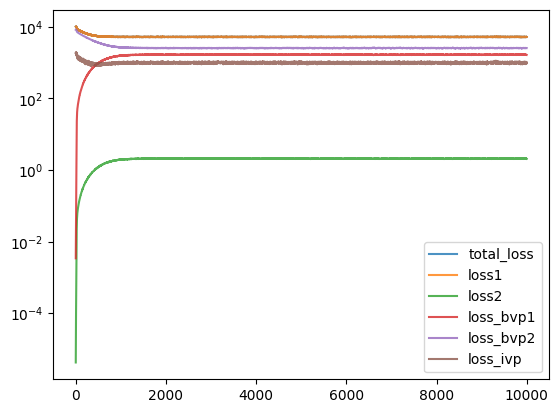

In [57]:
loss_df.plot(logy=True,alpha=0.8)

<Axes: >

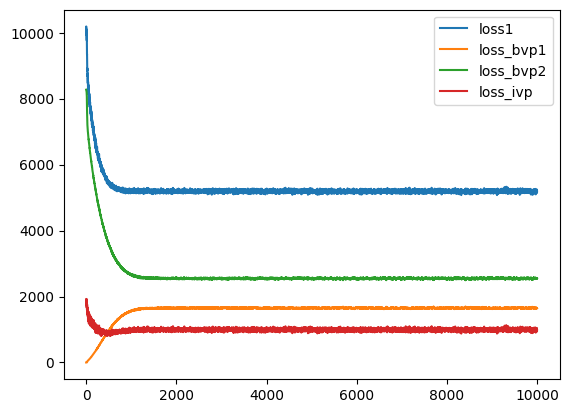

In [44]:
loss_df[["loss1","loss_bvp1","loss_bvp2","loss_ivp"]].plot()

### Evaluation

In [45]:
def eur_call_analytical_price(S, t, K, sigma):
    t2m = t  # Time to maturity (assumed in years)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m) / (sigma * torch.sqrt(t2m))
    d2 = d1 - sigma * torch.sqrt(t2m)
    # Normal cumulative distribution function (CDF)
    N0 = lambda value: 0.5 * (1 + torch.erf(value / (2**0.5)))
    Nd1 = N0(d1)
    Nd2 = N0(d2)
    # Calculate the option price
    C = S * Nd1 - K * Nd2 * torch.exp(-r * t2m)
    return C

In [46]:
eur_call_analytical_price(torch.tensor([80]),torch.tensor([1]),torch.tensor([70]), sigma =0.30)

tensor([17.0150])

In [47]:
X_test,_ = get_diff_data(2000)
t_test = torch.from_numpy(X_test[:,0]).float()
S_test = torch.from_numpy(X_test[:,1]).float()

y_analytical_test = eur_call_analytical_price(S_test,t_test,torch.tensor([K]), sigma = sigma)

In [48]:
with torch.no_grad():
  y_pinn_test = model(torch.from_numpy(X_test).float())

Text(0.5, 1.0, 'European Call Option pricing')

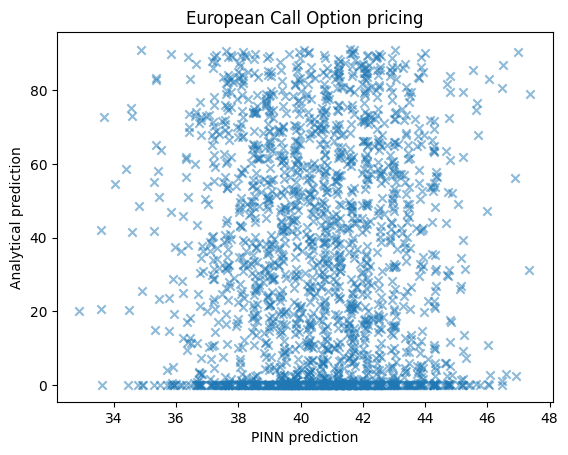

In [49]:
plt.scatter(x= y_pinn_test.detach().numpy(), y = y_analytical_test.detach().numpy(), marker = "x", alpha = 0.5)
plt.xlabel("PINN prediction")
plt.ylabel("Analytical prediction")
plt.title("European Call Option pricing")

In [50]:
y_pinn_test.detach().numpy().shape

(2000, 1)

In [52]:
np.corrcoef(y_pinn_test.detach().numpy().reshape(2000,),y_analytical_test.detach().numpy())

array([[ 1.       , -0.0299319],
       [-0.0299319,  1.       ]])

In [ ]:
%matplotlib inline

In [ ]:
S, T = np.meshgrid(X_test[:,1], X_test[:,0])
# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(S_test, t_test, y_analytical_test, c='b', marker='o')
ax.set_title("Analytical Soln")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=10, azim=50)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(S_test, t_test, y_pinn_test.detach().numpy(), c='b', marker='o')
ax.set_title("PINN prediction")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=10, azim=50)